# Power System Expansion Optimization Model 3.1
* Author: Xin Chen 
* Created on [08/12/2022]
* Decisions: 
1- Site & size of renewables and storage;
2- Retirement of conventional generators;

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

* Modified on [8/28/2022] 
* Implementation delicated to ERCOT system

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

* Modified on [9/2/2022]
* To speedup the solution, reduce the storage model to be 100% charging/discharging efficiency
* Consider no load shedding

* Modified on [9/6/2022]
* Use all locations to install solar, wind, and storage

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
* Modified on [9/11/2022]
* Consider multiple scenarios 


In [1]:
using JuMP, PowerModels, Gurobi, Plots,  CSV, DataFrames, LinearAlgebra, TickTock 

# 1 - Read Power Grid Info From CSV Files

In [3]:
# Total simulation time steps 
num_time_sim = 12 # total: 8784
dt = 2  # hour resolution
time_ini = 5375-22 # 5375-17 #  
T_sim = time_ini:dt:(time_ini + dt*num_time_sim - 1)

# ------------------ Buses ---------------------
bus_data = DataFrame(CSV.File("ERCOTSystem\\texas_bus.csv"))
num_bus = size(bus_data, 1)
bus_data.rowindex = 1:num_bus  # add a row order index
print("Total bus number is ", num_bus, "\n")

# ------------------ Loads ------------------
# (net load of nodal hydro generation)
load_data = DataFrame(CSV.File("ERCOTSystem\\loads.csv"))
timeslots = load_data[!,"UTC Time"]
num_time = size(load_data,1)
num_load = size(load_data,2) - 1
print("Total time number is ", num_time, "\n")

# 1 - direct from load csv that arrange load in the order of bus
p_load_t_all = Matrix(load_data[:,2:end])'/100    # unit: MW
p_load_t = p_load_t_all[:, T_sim]

p_load_max_t = abs.(p_load_t);
p_load_min_t = 0.8*p_load_max_t;

# total load over time
total_load_t = sum(p_load_t_all, dims=1)

# Load Peak Time
max_L_index = findfirst(x -> x == maximum(total_load_t), total_load_t)[2]
print("Load Peak: ", maximum(total_load_t), "(MW) at ", timeslots[max_L_index], "\n", "Time Index: ", max_L_index, "\n")
#plot((5375-17-24*10:5375+7+24*10),total_load_t[5375-17-24*10:5375+7+24*10], xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Total Load Trajectory Over One Year")

# Load Shedding 
ratio_shed_t = 0.2 
ratio_shed_all = 0.2
L_shed_max_t = ratio_shed_t*total_load_t
L_shed_max = ratio_shed_all*sum(total_load_t)

#plot load trajectories
# L1 = plot(total_load_t', xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Total Load Trajectory Over One Year")
# display(L1)
# ------------------ Branch ------------------
branch_data = DataFrame(CSV.File("ERCOTSystem\\texas_branch.csv"))
num_branch = size(branch_data, 1)
print("Total branch number is ", num_branch)

# construct key branch matrices 
A_nb = zeros(num_bus, num_branch); #node-branch incidence matrix
X_bn = zeros(num_branch, num_bus)  #branch-node resistance matrix
P_br_max = zeros(num_branch, num_time_sim);  # branch transmission capacity
for i = 1:num_branch
    P_br_max[i,:] = (branch_data[i,:].rateA + branch_data[i,:].rateB + branch_data[i,:].rateC)*ones(1,num_time_sim);
    
    f_bus_id = branch_data[i,:].from_bus_id
    t_bus_id = branch_data[i,:].to_bus_id
    f_bus = bus_data[bus_data.bus_id .== f_bus_id, :].rowindex
    t_bus = bus_data[bus_data.bus_id .== t_bus_id, :].rowindex
    
    if length(f_bus)>=2 || length(t_bus)>=2
        print("Error in bus selection!") # in case of getting multiple buses
    end
    
    x_br  = branch_data[i,:].x
    
    X_bn[i, f_bus] .=  1/x_br
    X_bn[i, t_bus] .= -1/x_br
    A_nb[f_bus, i] .=  1 
    A_nb[t_bus, i] .= -1 
end

P_br_min = - P_br_max;

Total bus number is 2000
Total time number is 8784
Load Peak: 70936.79000000001(MW) at 2016-08-11 22:00:00
Time Index: 5375
Total branch number is 3206

# 2- Devices Parameters

In [5]:
# nodal solar/wind max installation capacity
cap_sw_data = DataFrame(CSV.File("ERCOTSystem\\CPA_to_nodes.csv"))
cap_sw_data = coalesce.(cap_sw_data, 0.0)

# ------------------ Solar ------------------
solar_data = DataFrame(CSV.File("ERCOTSystem\\solars.csv"))
coe_PV_t_all = Matrix(solar_data[:,2:end])'/100    # unit: MW
coe_PV_t = coe_PV_t_all[:,T_sim]
# nodal total yearly solar coefficient 
coe_PV_all = sum(coe_PV_t_all, dims=2)

# plot solar power trajectories
# f1pv = plot(sum(coe_PV_t_all, dims=1)',  xlabel = "Time (h)", ylabel = "PV Gen. Factor") #seriestype = :scatter,
# f2pv = plot(coe_PV_all, xlabel = "Node Index", ylabel = "Yearly PV Energy (MWh) per 1MW")
# display(plot(f1pv, f2pv, layout = (2, 1), legend = false))

cap_PV = cap_sw_data[:,2] # unit: MW

# ------------------ Wind ------------------
wind_data = DataFrame(CSV.File("ERCOTSystem\\winds.csv"))
coe_WD_t_all = Matrix(wind_data[:,2:end])'/100    # unit: MW
coe_WD_t = coe_WD_t_all[:,T_sim]
# nodal total yearly wind coefficient
coe_WD_all = sum(coe_WD_t_all, dims=2)

# plot wind power trajectories
# f1wd = plot(sum(coe_WD_t_all, dims = 1)', xlabel = "Time (h)", ylabel = "Wind Gen. Factor")# seriestype = :scatter,
# f2wd = plot(coe_WD_all, xlabel = "Node Index", ylabel = "Yearly Wind Energy (MWh) per 1MW")
# display(plot(f1wd, f2wd, layout = (2, 1), legend = false))

cap_WD = cap_sw_data[:,3];

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.274478e+08
      1       2.035936e+08      -1.238542e+08 |        4
      2       2.013280e+08      -2.265553e+06 |        4
      3       2.010565e+08      -2.715124e+05 |        4
      4       2.008770e+08      -1.795224e+05 |        4
      5       2.000973e+08      -7.796665e+05 |        4
      6       1.995336e+08      -5.637476e+05 |        4
      7       1.987863e+08      -7.472377e+05 |        4
      8       1.981695e+08      -6.168094e+05 |        4
      9       1.980675e+08      -1.020496e+05 |        2
     10       1.978943e+08      -1.732089e+05 |        2
     11       1.978383e+08      -5.594985e+04 |        0
     12       1.978383e+08       0.000000e+00 |        0
K-means converged with 12 iterations (objv = 1.9783831849850315e8)
Number of days in clusters: [60, 70, 179, 57]
Peak Load is 56623.81 (MW)
Peak Load is 47611.175 (MW)
P

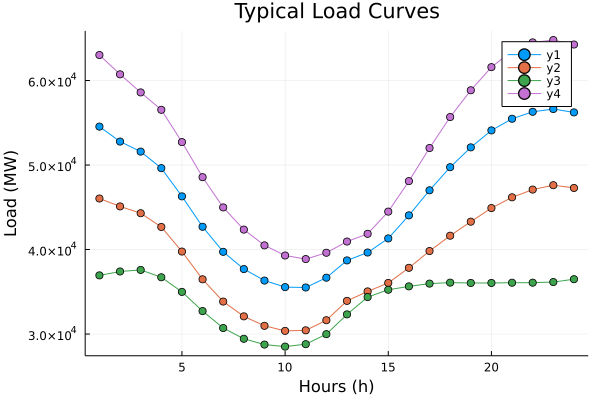

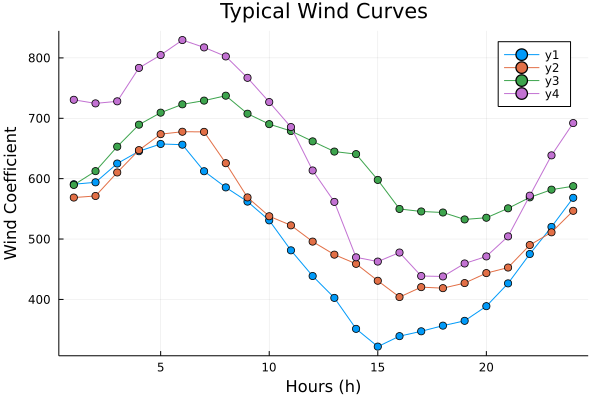

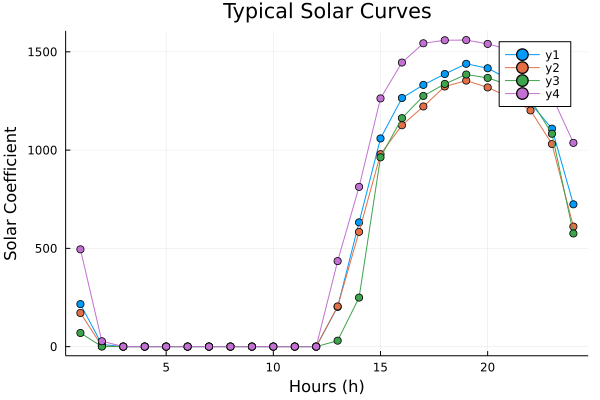

In [6]:
# ============= Select K typical days by K-means clustering ===========
using Clustering

# convert data by days
num_day = Int(num_time/24)  # 366 days

coe_WD_day_all = zeros(num_bus*24,num_day)
coe_PV_day_all = zeros(num_bus*24,num_day)
p_load_day_all = zeros(num_bus*24,num_day)
for i = 1:num_day
   coe_WD_day_all[:,i] = vec(coe_WD_t_all[:,24*i-23:24*i]);
   coe_PV_day_all[:,i] = vec(coe_PV_t_all[:,24*i-23:24*i]);
   p_load_day_all[:,i] = vec(p_load_t_all[:,24*i-23:24*i]);  
end

#p_load_day_all_nor = abs.(p_load_day_all)./(maximum(abs.(p_load_day_all), dims = 2).+1e-8)

feature_day = vcat(p_load_day_all, coe_WD_day_all, coe_PV_day_all)

K_day = 4 # number of clusters
cluster_days = kmeans(feature_day, K_day; maxiter=500, display=:iter)
typical_days = cluster_days.centers; # get the cluster centers
Assign_day = assignments(cluster_days) # get the assignments of points to clusters
Count_day = counts(cluster_days) # number of points in each cluster
print("Number of days in clusters: ", Count_day,"\n")

# Load curves in typical days
load_typical = sum(reshape(typical_days[1:num_bus*24,1],(num_bus,24) ),dims=1)
fig_ty = plot(load_typical', xlabel = "Hours (h)",markershape =:circle, ylabel = "Load (MW)", title = "Typical Load Curves")
print("Peak Load is ", round(maximum(load_typical),digits=3), " (MW)\n")
for i = 2:K_day
    load_typical = sum(reshape(typical_days[1:num_bus*24,i],(num_bus,24)),dims=1)
    print("Peak Load is ", round(maximum(load_typical),digits=3), " (MW)\n")
    fig_ty = plot!(load_typical', xlabel = "Hours (h)", markershape =:circle, ylabel = "Load (MW)", title = "Typical Load Curves") 
end
display(fig_ty)

# wind curve
wd_typical = sum(reshape(typical_days[num_bus*24+1:2*num_bus*24,1],(num_bus,24)),dims=1)
fig_ty = plot(wd_typical', xlabel = "Hours (h)",markershape =:circle, ylabel = "Wind Coefficient", title = "Typical Wind Curves") 
for i = 2:K_day
    wd_typical = sum(reshape(typical_days[num_bus*24+1:2*num_bus*24,i],(num_bus,24)),dims=1)
    fig_ty = plot!(wd_typical', xlabel = "Hours (h)", markershape =:circle, ylabel = "Wind Coefficient", title = "Typical Wind Curves") 
end
display(fig_ty)

#Solar curve
pv_typical = sum(reshape(typical_days[2*num_bus*24+1:3*num_bus*24,1],(num_bus,24)),dims=1)
fig_ty = plot(pv_typical', xlabel = "Hours (h)",markershape =:circle, ylabel = "Solar Coefficient", title = "Typical Solar Curves") 
for i = 2:K_day
    pv_typical = sum(reshape(typical_days[2*num_bus*24+1:3*num_bus*24,i],(num_bus,24)),dims=1)
    fig_ty = plot!(pv_typical', xlabel = "Hours (h)", markershape =:circle, ylabel = "Solar Coefficient", title = "Typical Solar Curves") 
end
display(fig_ty)

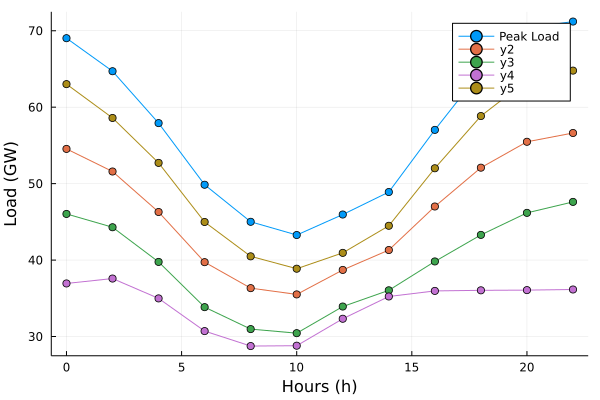

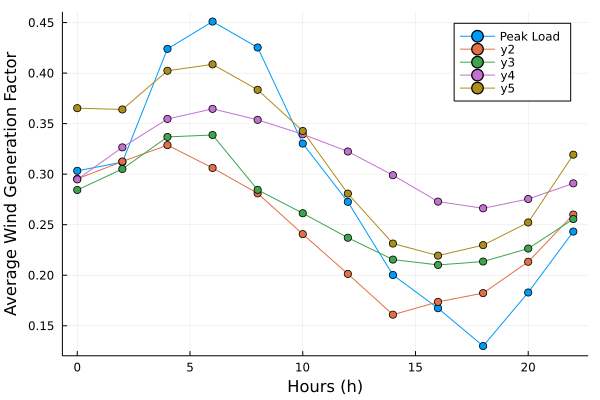

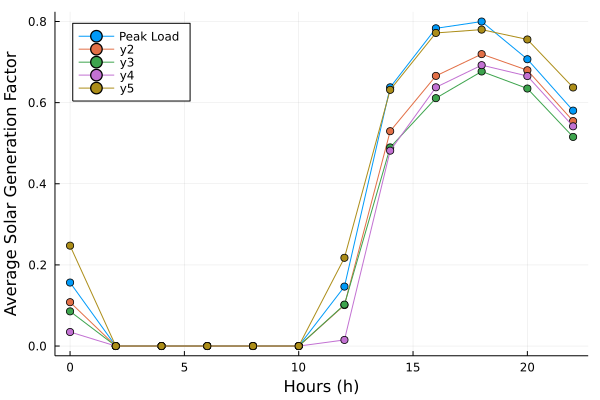

In [7]:
# Define Simulation Scenarios
num_scenario = K_day + 1

coe_PV_t_sim = zeros(num_bus, num_time_sim, num_scenario)
coe_WD_t_sim = zeros(num_bus, num_time_sim, num_scenario)
p_load_t_sim = zeros(num_bus, num_time_sim, num_scenario)

# extreme day
p_load_t_sim[:,:,1] = p_load_max_t
coe_WD_t_sim[:,:,1] = coe_WD_t
coe_PV_t_sim[:,:,1] = coe_PV_t;

for s = 2:num_scenario
    p_load_t_sim[:,:,s] = reshape(typical_days[1:num_bus*24,s-1],(num_bus,24))[:,1:dt:24]
    coe_WD_t_sim[:,:,s] = reshape(typical_days[num_bus*24+1:2*num_bus*24,s-1],(num_bus),24)[:,1:dt:24]
    coe_PV_t_sim[:,:,s] = reshape(typical_days[2*num_bus*24+1:3*num_bus*24,s-1],(num_bus),24)[:,1:dt:24]
end

days_sce = vcat(1,Count_day);

t_plot = (0:2:22)

fsim1 = plot(t_plot, sum(p_load_t_sim[:,:,1], dims = 1)'/1e3, label = "Peak Load", xlabel = "Hours (h)",markershape =:circle, ylabel = "Load (GW)" )
for s = 2:num_scenario
  fsim1 = plot!(t_plot, sum(p_load_t_sim[:,:,s], dims = 1)'/1e3,xlabel = "Hours (h)",markershape =:circle, ylabel = "Load (GW)")
end
display(fsim1)

fsim2 = plot(t_plot, sum(coe_WD_t_sim[:,:,1], dims = 1)'/2e3, label = "Peak Load", xlabel = "Hours (h)",markershape =:circle, ylabel = "Average Wind Generation Factor" )
for s = 2:num_scenario
  fsim2 = plot!(t_plot, sum(coe_WD_t_sim[:,:,s], dims = 1)'/2e3,xlabel = "Hours (h)",markershape =:circle, ylabel = "Average Wind Generation Factor" )
end
display(fsim2)

fsim3 = plot(t_plot, sum(coe_PV_t_sim[:,:,1], dims = 1)'/2e3, label = "Peak Load", xlabel = "Hours (h)",markershape =:circle, ylabel = "Average Solar Generation Factor" )
for s = 2:num_scenario
  fsim3 = plot!(t_plot, sum(coe_PV_t_sim[:,:,s], dims = 1)'/2e3,legend=:topleft, xlabel = "Hours (h)",markershape =:circle, ylabel = "Average Solar Generation Factor" )
end
display(fsim3)


-5:2:17

Total power plants number is 598
Power plant types include String7["wind", "solar", "ng", "coal", "hydro", "nuclear"]
solar: 2460.2 MW (2.229%) 
wind: 19062.63 MW (17.273%) 
natural gas: 68642.42 MW (62.198%) 
coal: 14501.59 MW (13.14%) 
hydro: 555.1 MW (0.503%) 
nuclear: 5138.6 MW (4.656%) 
clean energy: 27216.53 MW (24.661%) 
total: 110360.54 MW 


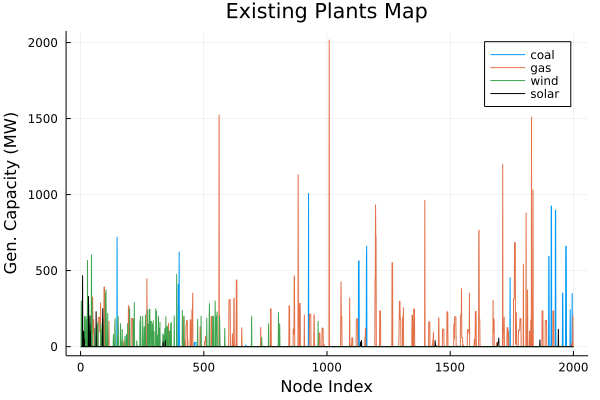

In [59]:
# ------------------ All Existing Power Plants ------------------
plant_data = DataFrame(CSV.File("ERCOTSystem\\texas_plant.csv"))
num_plant = size(plant_data, 1)
plant_data.rowindex = 1:num_plant  # add a row order index
print("Total power plants number is ", num_plant, "\n")

print("Power plant types include ", unique(plant_data.type),"\n")
plant_data_solar = plant_data[ plant_data.type .== "solar", :]
plant_data_wind = plant_data[ plant_data.type .== "wind", :]
plant_data_ng = plant_data[ plant_data.type .== "ng", :] 
plant_data_coal = plant_data[ plant_data.type .== "coal", :]
plant_data_hydro = plant_data[ plant_data.type .== "hydro", :] 
plant_data_nuclear = plant_data[ plant_data.type .== "nuclear", :] 
                            
pg_solar = sum(plant_data_solar.Pmax)
pg_wind = sum(plant_data_wind.Pmax)
pg_ng = sum(plant_data_ng.Pmax)
pg_coal = sum(plant_data_coal.Pmax)
pg_hydro = sum(plant_data_hydro.Pmax)
pg_nuclear = sum(plant_data_nuclear.Pmax)
pg_sum = sum(plant_data.Pmax)

labels = ["solar"; "wind"; "gas";"coal"; "hydro"; "nuclear"] 
sizes = [pg_solar; pg_wind; pg_ng; pg_coal; pg_hydro; pg_nuclear]
print("solar: ", round(pg_solar, digits =3), " MW (", round(pg_solar/pg_sum*100, digits =3), "%) \n", 
      "wind: ", round(pg_wind, digits =3), " MW (", round(pg_wind/pg_sum*100, digits =3), "%) \n", 
      "natural gas: ", round(pg_ng, digits =3), " MW (", round(pg_ng/pg_sum*100, digits =3), "%) \n", 
      "coal: ",  round(pg_coal, digits =3), " MW (", round(pg_coal/pg_sum*100, digits =3), "%) \n", 
      "hydro: ",  round(pg_hydro, digits =3), " MW (", round(pg_hydro/pg_sum*100, digits =3), "%) \n", 
      "nuclear: ",  round(pg_nuclear, digits =3), " MW (", round(pg_nuclear/pg_sum*100, digits =3), "%) \n", 
      "clean energy: ",  round(pg_nuclear+pg_solar+pg_wind+pg_hydro, digits =3), " MW (", round((pg_nuclear+pg_solar+pg_wind+pg_hydro)/pg_sum*100, digits =3), "%) \n", 
      "total: ", round(pg_sum, digits =3), " MW \n")

#plot(labels, sizes,seriestype = :pie )

# ----------------- Parameters for Existing Power Plants -----------
num_gen_ng      = size(plant_data_ng,1)
num_gen_coal    = size(plant_data_coal,1)
num_gen_solar   = size(plant_data_solar,1)
num_gen_wind    = size(plant_data_wind,1)
num_gen_hydro   = size(plant_data_hydro,1)
num_gen_nuclear = size(plant_data_nuclear,1)

# generation capacity over time
Pmin_ng = plant_data_ng.Pmin.*ones(1,num_time_sim)
Pmax_ng = plant_data_ng.Pmax.*ones(1,num_time_sim)
ramp_ng_max = dt*2*plant_data_ng.ramp_30
ramp_ng_min = - ramp_ng_max 

Pmin_coal = plant_data_coal.Pmin.*ones(1,num_time_sim)
Pmax_coal = plant_data_coal.Pmax.*ones(1,num_time_sim)
ramp_coal_max = dt*2*plant_data_coal.ramp_30
ramp_coal_min = - ramp_coal_max 

# Construct nodal matrices for power flow
A_coal = zeros(num_bus,num_gen_coal)
A_ng = zeros(num_bus,num_gen_ng)
A_wind = zeros(num_bus,num_gen_wind)
A_solar = zeros(num_bus,num_gen_solar)
A_nuclear = zeros(num_bus,num_gen_nuclear)

for i = 1:num_gen_coal
    bus_index = bus_data[bus_data.bus_id .== plant_data_coal[i,:].bus_id, :].rowindex[1]
    A_coal[bus_index, i] = 1
end

for i = 1:num_gen_ng
    bus_index = bus_data[bus_data.bus_id .== plant_data_ng[i,:].bus_id, :].rowindex[1]
    A_ng[bus_index, i] = 1
end

for i = 1:num_gen_nuclear
    bus_index = bus_data[bus_data.bus_id .== plant_data_nuclear[i,:].bus_id, :].rowindex[1]
    A_nuclear[bus_index, i] = 1
end
P_nuclear = plant_data_nuclear.Pg.*ones(1,num_time_sim)

solar_index = Int32.(zeros(num_gen_solar,1))
for i =1: num_gen_solar
    bus_index = bus_data[bus_data.bus_id .== plant_data_solar[i,:].bus_id, :].rowindex[1]
    A_solar[bus_index, i] = 1
    solar_index[i] = bus_index
end
Pmax_solar = plant_data_solar.Pmax.*coe_PV_t_sim[solar_index[:,1], :,:]

wind_index = Int32.(zeros(num_gen_wind,1))
for i =1: num_gen_wind
    bus_index = bus_data[bus_data.bus_id .== plant_data_wind[i,:].bus_id, :].rowindex[1]
    A_wind[bus_index, i] = 1
    wind_index[i] = bus_index 
end
Pmax_wind = plant_data_wind.Pmax.*coe_WD_t_sim[wind_index[:,1], :,:];

# Energy Storage 
cap_ES_max = 2000 # MWh
cap_ES = cap_ES_max*ones(num_bus,1)[:,1]
#cap_ES[800:end] .= 0
 
p_dis_max = 0.25 # MW
p_cha_max = 0.25 # MW
e_max = 1  #MWh
ES_ini = 0.5  # initial SOC is 50%
kap_ES = 0.99 # 100% no leakage

alp_cha = sqrt(0.85)
alp_dis = sqrt(0.85)

# Cost parameters
gencost_data = DataFrame(CSV.File("ERCOTSystem\\texas_gencost.csv"))

c_gen_ng = hcat(gencost_data[plant_data_ng.rowindex,:].c2, 
                gencost_data[plant_data_ng.rowindex,:].c1, 
                gencost_data[plant_data_ng.rowindex,:].c0)/1e3 

c_gen_coal = hcat(gencost_data[plant_data_coal.rowindex,:].c2, 
                  gencost_data[plant_data_coal.rowindex,:].c1, 
                  gencost_data[plant_data_coal.rowindex,:].c0)/1e3  

# investment
c_PV_invest = 890 # k$/MW
c_WD_invest = 1212 # k$/MW
c_ES_invest = 369 # k$/MWh
c_curtail = 0.002 # k$/MWh
c_ES_oper = 0.001  # k$/MWh
c_loadshed = 5  # k$/MWh
c_coal_retire = 117 # k$/MW
c_ng_retire = 15 # k$/MW

# Existing Nodal Capacity of Generation Disrribution
nc_coal = A_coal*Pmax_coal[:,1]
nc_ng = A_ng*Pmax_ng[:,1]
nc_wind = A_wind*plant_data_wind.Pmax
nc_solar = A_solar*plant_data_solar.Pmax;

plot(nc_coal, label = "coal")
plot!(nc_ng, label= "gas")
plot!(nc_wind, label= "wind")
plot!(nc_solar, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (MW)", linecolor = "black", title = "Existing Plants Map")

# 3- Optimal Planning Model

In [94]:
## ================= Select Optimizer =====================
model_plan = Model(Gurobi.Optimizer)

num_scenario = 5

## ================= Create Variables and Constraints =====================
# Solar  
@variable(model_plan, 0 <= w_PV_var[1:num_bus])
@variable(model_plan, 0 <= p_PV_var[1:num_bus, 1:num_time_sim, 1:num_scenario])
@constraint(model_plan, w_PV_var .<= cap_PV)

# Wind  
@variable(model_plan, 0 <= w_WD_var[1:num_bus])
@variable(model_plan, 0 <= p_WD_var[1:num_bus, 1:num_time_sim, 1:num_scenario])
@constraint(model_plan, w_WD_var .<= cap_WD)


# Existing Solar and Wind
@variable(model_plan, 0 <= p_solar_var[1:num_gen_solar, 1:num_time_sim, 1:num_scenario])
@variable(model_plan, 0 <= p_wind_var[1:num_gen_wind, 1:num_time_sim, 1:num_scenario])

for s=1:num_scenario
   @constraint(model_plan, p_PV_var[:,:,s] .<= w_PV_var.*coe_PV_t_sim[:,:,s])
   @constraint(model_plan, p_WD_var[:,:,s] .<= w_WD_var.*coe_WD_t_sim[:,:,s])
   @constraint(model_plan, p_wind_var[:,:,s] .<= Pmax_wind[:,:,s])
   @constraint(model_plan, p_solar_var[:,:,s] .<= Pmax_solar[:,:,s])
end


# Coal Generators
#@variable(model_plan, z_coal_var[1:num_gen_coal], Bin) # coal
@variable(model_plan, 0 <= z_coal_var[1:num_gen_coal] <= 1) # coal
@variable(model_plan, p_coal_var[1:num_gen_coal, 1:num_time_sim, 1:num_scenario])

for s = 1:num_scenario
   @constraint(model_plan, z_coal_var.*Pmin_coal .<= p_coal_var[:,:,s])
   @constraint(model_plan, p_coal_var[:,:,s] .<= z_coal_var.*Pmax_coal)
   for t = 2:num_time_sim
      @constraint(model_plan,  ramp_coal_min .<= p_coal_var[:,t,s] - p_coal_var[:,t-1,s] .<= ramp_coal_max )
   end
end

# Natural Gass
#@variable(model_plan, z_ng_var[1:num_gen_ng], Bin) # natural gas
@variable(model_plan, 0 <= z_ng_var[1:num_gen_ng] <= 1) # natural gas
@variable(model_plan, p_ng_var[1:num_gen_ng, 1:num_time_sim, 1:num_scenario])

for s = 1:num_scenario
   @constraint(model_plan, z_ng_var.*Pmin_ng .<= p_ng_var[:,:,s])
   @constraint(model_plan, p_ng_var[:,:,s] .<= z_ng_var.*Pmax_ng);
   for t = 2:num_time_sim
      @constraint(model_plan,  ramp_ng_min .<= p_ng_var[:,t,s] - p_ng_var[:,t-1,s] .<= ramp_ng_max )
   end
end
# Adjustable Loads
#@variable(model_plan, 0 <= p_load_var[1:num_load, 1:num_time_sim])
#@constraint(model_plan, p_load_min_t .<= p_load_var .<= p_load_max_t)

##  Energy Storage
alp_cha = 1
alp_dis = 1

# --------------------------- full model ------------------------
# @variable(model_plan, nu_ES_var[1:num_bus, 1:num_time_sim], Bin)
@variable(model_plan, 0 <= nu_ES_var[1:num_bus, 1:num_time_sim,1:num_scenario] <= 1)
@variable(model_plan, 0 <= w_ES_var[1:num_bus])
@variable(model_plan, 0 <= y_ES_var[1:num_bus, 1:num_time_sim,1:num_scenario] )
@variable(model_plan, 0 <= p_dis_var[1:num_bus, 1:num_time_sim,1:num_scenario])
@variable(model_plan, 0 <= p_cha_var[1:num_bus, 1:num_time_sim,1:num_scenario])
@variable(model_plan, 0 <= e_ES_var[1:num_bus, 1:num_time_sim,1:num_scenario])

big_M = 1e3
@constraint(model_plan, w_ES_var .<= cap_ES)

for s = 1:num_scenario
   @constraint(model_plan, p_dis_var[:,:,s] .<= p_dis_max*y_ES_var[:,:,s] )
   @constraint(model_plan, p_cha_var[:,:,s] .<= p_cha_max*( w_ES_var*ones(1,num_time_sim) - y_ES_var[:,:,s]))
   @constraint(model_plan, y_ES_var[:,:,s] .<= w_ES_var*ones(1,num_time_sim)) 
   @constraint(model_plan, y_ES_var[:,:,s] .<= big_M*nu_ES_var[:,:,s])

   for t = 1:num_time_sim
       @constraint(model_plan, big_M*nu_ES_var[:,t,s] - big_M*ones(num_bus,1) + w_ES_var .<= y_ES_var[:,t,s])
       if t == 1
           @constraint(model_plan, e_ES_var[:,t,s] .== kap_ES*(ES_ini*e_max*w_ES_var) + dt*(alp_cha*p_cha_var[:,t,s] - 1/alp_dis*p_dis_var[:,t,s]))
       else
           @constraint(model_plan, e_ES_var[:,t,s] .== kap_ES*e_ES_var[:,t-1,s] + dt*(alp_cha*p_cha_var[:,t,s] - 1/alp_dis*p_dis_var[:,t,s]))
       end
       @constraint(model_plan, e_ES_var[:,t,s] .<= e_max*w_ES_var)
   end
   @constraint(model_plan, e_ES_var[:,num_time_sim,s] .== ES_ini*e_max*w_ES_var); # recover to the initial SOC
end

# # DC Power Flow
@variable(model_plan, P_br_var[1:num_branch, 1:num_time_sim,1:num_scenario])
@variable(model_plan, tha_var[1:(num_bus-1), 1:num_time_sim,1:num_scenario])
# Power Flow
for s = 1:num_scenario
   @constraint(model_plan, P_br_min .<= P_br_var[:,:,s] .<= P_br_max)
   @constraint(model_plan, P_br_var[:,:,s] .== X_bn[:,2:end]*tha_var[:,:,s])
   @constraint(model_plan, A_nb*P_br_var[:,:,s] .== p_PV_var[:,:,s] + p_WD_var[:,:,s] + p_dis_var[:,:,s] - p_cha_var[:,:,s]
                 - p_load_t_sim[:,:,s] + A_coal*p_coal_var[:,:,s] + A_ng*p_ng_var[:,:,s] 
                 + A_wind*p_wind_var[:,:,s] + A_solar*p_solar_var[:,:,s] + A_nuclear*P_nuclear);
end
# Renewable Penetration
renew_pene = 0.8
for s = 1:num_scenario
   @constraint(model_plan, sum(p_coal_var[:,:,s]) + sum(p_ng_var[:,:,s]) <= (1 - renew_pene)*sum(p_load_t_sim[:,:,s]));
end
#@constraint(model_plan, sum(w_PV_var + w_WD_var) + sum() >= gam_C*sum(z_gen_var.*cap_gen) )

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31


In [95]:
## ================= Define Objective =====================
num_years = 10

Obj_invest = sum(c_PV_invest*w_PV_var) +  sum(c_WD_invest*w_WD_var) + sum(c_ES_invest*w_ES_var)
            #  + (   sum(c_coal_retire*(ones(num_gen_coal,1)-z_coal_var).*Pmax_coal[:,1]) 
              # + sum(c_ng_retire*(ones(num_gen_ng,1)-z_ng_var).*Pmax_ng[:,1]) )

Obj_opera_year = 0*w_PV_var[1]
Obj_opera = zeros(num_scenario,1)*w_PV_var[1]

for s = 1:num_scenario
   Obj_opera[s] =  c_curtail*(sum( w_PV_var.*coe_PV_t_sim[:,:,s] - p_PV_var[:,:,s]) + sum( w_WD_var.*coe_WD_t_sim[:,:,s] - p_WD_var[:,:,s])
               + sum(Pmax_wind[:,:,s] - p_wind_var[:,:,s]) + sum(Pmax_solar[:,:,s]-p_solar_var[:,:,s])) + c_ES_oper*sum(p_dis_var[:,:,s] + p_cha_var[:,:,s])
          
   for i = 1:num_gen_coal
       Obj_opera[s] =  Obj_opera[s] + sum(c_gen_coal[i,2]*p_coal_var[i,:,s] + z_coal_var[i]*c_gen_coal[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_coal[i,1]*(p_coal_var[i,:,s].^2) )
   end

   for i = 1:num_gen_ng
       Obj_opera[s] =  Obj_opera[s] + sum( c_gen_ng[i,2]*p_ng_var[i,:,s] + z_ng_var[i]*c_gen_ng[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_ng[i,1]*(p_ng_var[i,:,s].^2))
   end
    Obj_opera_year = Obj_opera_year + days_sce[s]*Obj_opera[s]
end

Obj_exp = Obj_invest + num_years*Obj_opera_year

@objective(model_plan, Min, Obj_exp);



In [96]:
## ================= Solve model =======================
tick()
optimize!(model_plan)
tock()

┌ Info:  started timer at: 2022-09-11T14:26:11.967
└ @ TickTock C:\Users\xin.chen\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1683230 rows, 1408444 columns and 4678915 nonzeros
Model fingerprint: 0xa32a7dec
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-02, 2e+05]
  Bounds range     [1e+00, 4e+03]
  RHS range        [6e-03, 1e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 809372 rows and 667289 columns
Presolve time: 5.70s
Presolved: 873858 rows, 741155 columns, 2942425 nonzeros

Ordering time: 17.23s
Elapsed ordering time = 17s
Elapsed ordering time = 21s
Elapsed ordering time = 25s
Elapsed ordering time = 30s
Elapsed ordering time = 35s
Elapsed ordering time = 38s
Elapsed ordering time = 40s
Elapsed ordering time = 45s
Elapsed ordering time = 50s
Elapsed ordering time = 55s
Elapsed ordering time = 56s
Elapsed ordering time = 60s
Elapsed ordering time = 65s
Elapsed order

┌ Info:         6759.6683994s: 1 hour, 52 minutes, 39 seconds, 668 milliseconds
└ @ TickTock C:\Users\xin.chen\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


In [97]:
# Get and Save optimal solution values
w_PV = value.(w_PV_var)
p_PV = value.(p_PV_var)
w_WD = value.(w_WD_var)
p_WD = value.(p_WD_var)
p_solar = value.(p_solar_var)
p_wind = value.(p_wind_var)
z_coal = value.(z_coal_var)
p_coal = value.(p_coal_var)
z_ng = value.(z_ng_var)
p_ng = value.(p_ng_var)
nu_ES = value.(nu_ES_var)
w_ES = value.(w_ES_var)
y_ES = value.(y_ES_var)
p_dis = value.(p_dis_var)
p_cha = value.(p_cha_var)
e_ES = value.(e_ES_var)
P_br = value.(P_br_var)
tha = value.(tha_var)
P_br_ava = P_br_max - abs.(P_br)  # ==0: binding line
p_load = p_load_max_t

## ================= Show Results =======================
E_solar = sum(p_PV) + sum(p_solar)
E_wind = sum(p_WD) + sum(p_wind)
E_coal = sum(p_coal)
E_ng = sum(p_ng)
E_nuclear = sum(P_nuclear)
E_gen = E_solar + E_wind + E_coal + E_ng + E_nuclear
E_load = sum(p_load)

labels = ["solar"; "wind"; "gas";"coal"; "nuclear"] 
sizes = [E_solar; E_wind; E_ng; E_coal; E_nuclear]
print("solar: ", round(E_solar, digits =3), " MWh (", round(E_solar/E_gen*100, digits =3), "%) \n", 
      "wind: ", round(E_wind, digits =3), " MWh (", round(E_wind/E_gen*100, digits =3), "%) \n", 
      "natural gas: ", round(E_ng, digits =3), " MWh (", round(E_ng/E_gen*100, digits =3), "%) \n", 
      "coal: ",  round(E_coal, digits =3), " MWh (", round(E_coal/E_gen*100, digits =3), "%) \n", 
      "nuclear: ",  round(E_nuclear, digits =3), " MWh (", round(E_nuclear/E_gen*100, digits =3), "%) \n", 
      "clean energy: ",  round(E_nuclear+E_solar+E_wind, digits =3), " MWh (", round((E_nuclear+E_solar+E_wind)/E_gen*100, digits =3), "%) \n", 
      "total generation: ", round(E_gen, digits =3), " MWh \n",
      "total load: ", round(E_load, digits =3), " MWh \n")


fig_energy = plot(labels, sizes,seriestype = :pie, title = "Energy Provider" )
display(fig_energy)


LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(3206), Base.OneTo(12), Base.OneTo(5)), must have singleton at dim 3

Total solar installation cap: 38.021 (GW)
Total wind installation cap: 64.508 (GW)
Total energy storage installation cap: 17.002 (GWh)


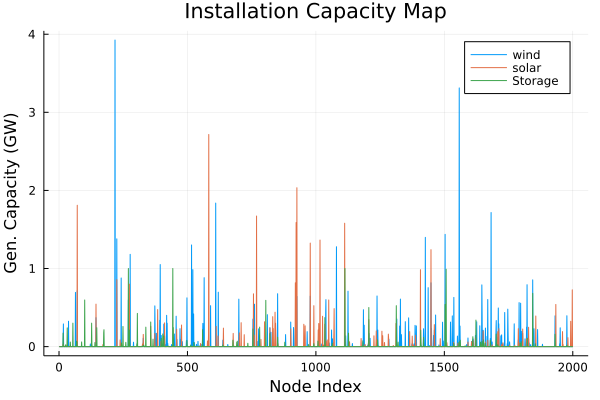

The objective (total cost) is 1.29060468318e8 
Investment Cost: 118.297 billion $
Solar Investment Cost: 33.839 billion $
Wind Investment Cost: 78.184 billion $
Storage Investment Cost: 6.274 billion $


In [98]:
# Planned Nodal Capacity of Generation Disrribution
print("Total solar installation cap: ", round(sum(w_PV)/1e3, digits =3)," (GW)\n")
print("Total wind installation cap: ", round(sum(w_WD)/1e3, digits =3)," (GW)\n")
print("Total energy storage installation cap: ", round(sum(w_ES)/1e3, digits =3)," (GWh)\n")

figr = plot(w_WD/1e3, label= "wind")
figr = plot!(w_PV/1e3, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (GW)",  title = "Installation Capacity Map")
figr = plot!(w_ES/1e3, label= "Storage")
display(figr)

# Output Solutions
print("The objective (total cost) is ", round(objective_value(model_plan),digits =3)," \n")
print("Investment Cost: ", round(value.(Obj_invest)/1e6,digits =3), " billion \$\n")
print("Solar Investment Cost: ", round(sum(c_PV_invest*(w_PV))/1e6,digits =3), " billion \$\n")
print("Wind Investment Cost: ", round(sum(c_WD_invest*w_WD)/1e6,digits =3), " billion \$\n")
print("Storage Investment Cost: ", round(sum(c_ES_invest*w_ES)/1e6,digits =3), " billion \$\n")
#print("Operational Cost: ", round(value.(Obj_opera),digits =3), " k\$\n")

In [90]:
 P_solar_t[1,:,:]'

3×12 adjoint(::Matrix{Float64}) with eltype Float64:
 8944.05  0.0  0.0  0.0  0.0  0.0  …  30901.0  34168.0  32106.5  28537.6
 4685.91  0.0  0.0  0.0  0.0  0.0     23789.7  25857.1  25834.6  22630.7
 1366.69  0.0  0.0  0.0  0.0  0.0     11708.2  11702.8  10793.1  10809.1

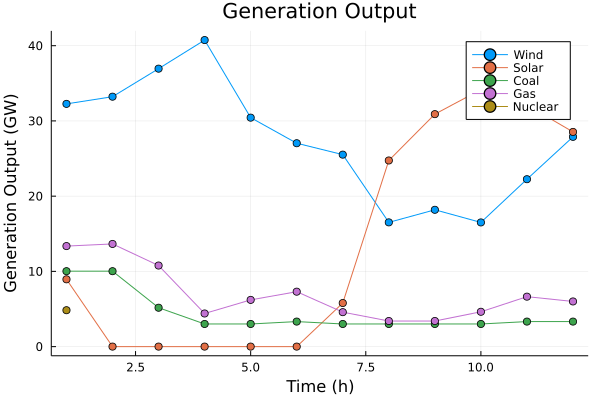

In [91]:
P_solar_t = sum(p_PV, dims=1)+sum(p_solar, dims=1)
P_solar_t = P_solar_t[1,:,:]'

P_wind_t = sum(p_wind, dims=1)+sum(p_WD, dims=1)
P_wind_t = P_wind_t[1,:,:]'

P_coal_t = sum(p_coal, dims =1)
P_coal_t = P_coal_t[1,:,:]'

P_ng_t = sum(p_ng, dims =1)
P_ng_t = P_ng_t[1,:,:]'

P_nuclear_t = sum(P_nuclear, dims =1)
P_nuclear_t = P_nuclear_t'[:,1]

plot(P_wind_t[1,:]/1e3, markershape =:circle, title = "Generation Output", label = "Wind", lw = 1)
plot!(P_solar_t[1,:]/1e3, markershape =:circle, title = "Generation Output", label = "Solar", lw = 1)
plot!(P_coal_t[1,:]/1e3, markershape =:circle, title = "Generation Output", label = "Coal", lw = 1)
plot!(P_ng_t[1,:]/1e3, markershape =:circle, title = "Generation Output", label = "Gas", lw = 1)
plot!(P_nuclear_t[1,:]/1e3, markershape =:circle, title = "Generation Output", label = "Nuclear", xlabel = "Time (h)", ylabel = "Generation Output (GW)", lw = 1)

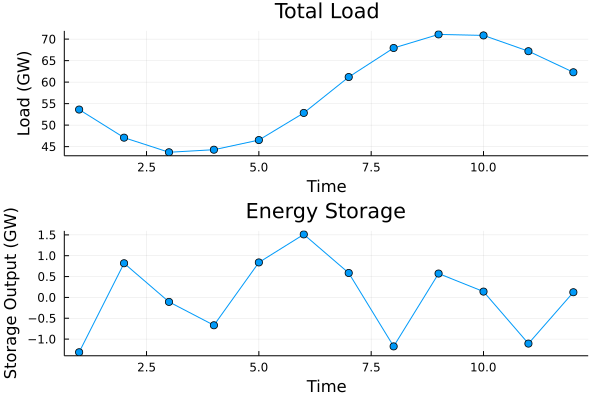

In [18]:
# Load
P_load_t = sum(value.(p_load_max_t), dims = 1)
r1fig = plot(P_load_t'/1e3, markershape =:circle, xlabel = "Time", ylabel = "Load (GW)", title = "Total Load")

# Energy Storage
# p_ES_t = sum(value.(p_ES_var), dims = 1)
p_ES_t = sum(value.(p_cha_var - p_dis_var), dims = 1)
r2fig = plot(p_ES_t'/1e3,  xlabel = "Time", ylabel = "Storage Output (GW)", title = "Energy Storage", markershape =:circle)

display(plot(r1fig, r2fig, layout = (2, 1), legend = false))

In [101]:
# Save and Read Data
using JLD2, Tables
jldsave("Testcase_16.jld2"; w_PV, p_PV, w_WD, p_WD, p_solar, p_wind, z_coal, p_coal,
                            z_ng, p_ng, nu_ES, w_ES, y_ES, p_dis, p_cha, e_ES, P_br, tha, P_br_ava);

CSV.write("solarinstall16.csv", Tables.table(w_PV), writeheader=false)
CSV.write("windinstall16.csv", Tables.table(w_WD), writeheader=false)
CSV.write("storageinstall16.csv", Tables.table(w_ES), writeheader=false)

br_bind_index = zeros(num_branch,num_time_sim)
for i = 1:num_branch
    for t = 1:num_time_sim
       if P_br_ava[i,t] <= 1
           br_bind_index[i,t] = 1
       end
    end
end

CSV.write("linebind16.csv", Tables.table(br_bind_index), writeheader= false)

# # Read Existing Solution Results
# datafile = jldopen("Testcase_14.jld2", "r")
# w_PV = read(datafile, "w_PV")
# p_PV = read(datafile, "p_PV") 
# w_WD = read(datafile, "w_WD")
# p_WD = read(datafile, "p_WD") 
# p_solar = read(datafile, "p_solar")
# p_wind = read(datafile, "p_wind")
# z_coal = read(datafile, "z_coal")
# p_coal = read(datafile, "p_coal")
# z_ng = read(datafile, "z_ng")
# p_ng = read(datafile, "p_ng") 
# nu_ES = read(datafile, "nu_ES") 
# w_ES = read(datafile, "w_ES")
# y_ES = read(datafile, "y_ES")
# p_dis = read(datafile, "p_dis") 
# p_cha = read(datafile, "p_cha") 
# e_ES = read(datafile, "e_ES") 
# P_br = read(datafile, "P_br") 
# tha = read(datafile, "tha")
# P_br_ava = read(datafile, "P_br_ava")
# close(datafile)

"linebind16.csv"

In [75]:
# Binding Branches
P_br_ava = P_br_max - abs.(P_br)
for t =1:num_time_sim
    for j = 1:num_branch
        if P_br_ava[j,t] <= 1e-6
            print("line ", j, " at time ", t, "\n")
        end
    end
end

line 12 at time 1
line 75 at time 1
line 273 at time 1
line 346 at time 1
line 349 at time 1
line 383 at time 1
line 412 at time 1
line 432 at time 1
line 440 at time 1
line 455 at time 1
line 460 at time 1
line 675 at time 1
line 749 at time 1
line 834 at time 1
line 847 at time 1
line 848 at time 1
line 1002 at time 1
line 1127 at time 1
line 1131 at time 1
line 1148 at time 1
line 1196 at time 1
line 1203 at time 1
line 1298 at time 1
line 1311 at time 1
line 1347 at time 1
line 1394 at time 1
line 1396 at time 1
line 1548 at time 1
line 1558 at time 1
line 1774 at time 1
line 1848 at time 1
line 1995 at time 1
line 2145 at time 1
line 2157 at time 1
line 2161 at time 1
line 2206 at time 1
line 2451 at time 1
line 2487 at time 1
line 2518 at time 1
line 2558 at time 1
line 2628 at time 1
line 2717 at time 1
line 2726 at time 1
line 2732 at time 1
line 2762 at time 1
line 2770 at time 1
line 2780 at time 1
line 2788 at time 1
line 2861 at time 1
line 2966 at time 1
line 3007 at time 

line 2861 at time 10
line 2871 at time 10
line 2966 at time 10
line 2986 at time 10
line 3007 at time 10
line 3028 at time 10
line 3119 at time 10
line 3154 at time 10
line 3179 at time 10
line 3201 at time 10
line 3203 at time 10
line 140 at time 11
line 141 at time 11
line 192 at time 11
line 208 at time 11
line 211 at time 11
line 376 at time 11
line 383 at time 11
line 431 at time 11
line 432 at time 11
line 496 at time 11
line 503 at time 11
line 526 at time 11
line 544 at time 11
line 559 at time 11
line 566 at time 11
line 567 at time 11
line 568 at time 11
line 577 at time 11
line 579 at time 11
line 580 at time 11
line 616 at time 11
line 617 at time 11
line 702 at time 11
line 711 at time 11
line 743 at time 11
line 805 at time 11
line 811 at time 11
line 846 at time 11
line 847 at time 11
line 935 at time 11
line 1036 at time 11
line 1130 at time 11
line 1156 at time 11
line 1157 at time 11
line 1311 at time 11
line 1374 at time 11
line 1375 at time 11
line 1380 at time 11
l

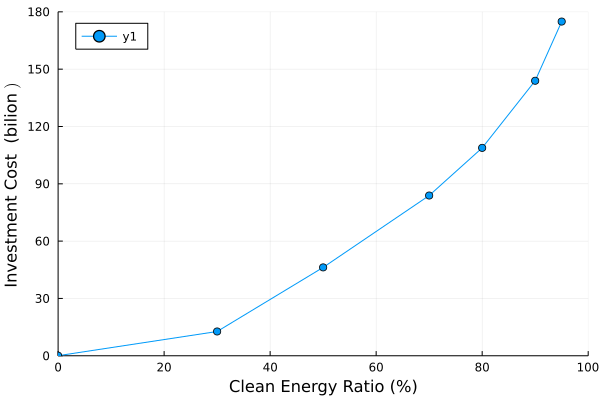

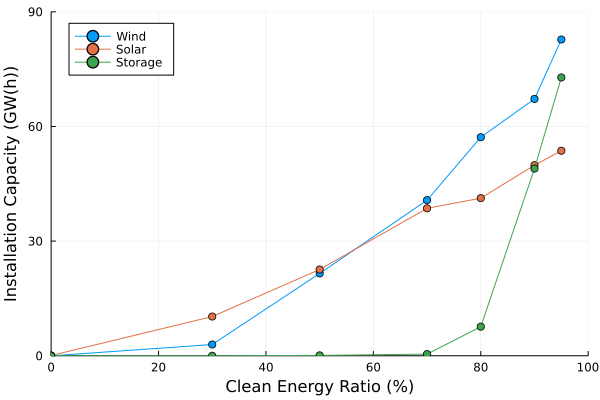

In [45]:
Invest_result = [0 0.07 0 0.078 0;
                 30 12.726 2.957 10.272 0;
                 50 46.258 21.551 22.582 0.108;
                 70 83.867 40.725 38.588 0.447;
                 80 108.8 57.189 41.247 7.615;
                 90 143.92 67.212 49.876 48.979;
                 95 174.9 82.759 53.647 72.827]
f1inv = plot(Invest_result[:,1], Invest_result[:,2], legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion \$) ",  markershape =:circle)
display(f1inv)
f2inv = plot(Invest_result[:,1], Invest_result[:,3],legend=:topleft, label = "Wind", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle)
f2inv = plot!(Invest_result[:,1], Invest_result[:,4],legend=:topleft,label = "Solar", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle)
f2inv = plot!(Invest_result[:,1], Invest_result[:,5],legend=:topleft,label = "Storage", xlims = (0,100),ylims = (0,90), xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle)
display(f2inv)

In [30]:
w_PV_var.*coe_PV_t_sim

2000×12×5 Array{AffExpr, 3}:
[:, :, 1] =
 0.22874999999999998 w_PV_var[1]    …  0.25946428571428565 w_PV_var[1]
 0.22589285714285712 w_PV_var[2]       0.24178571428571421 w_PV_var[2]
 0.300892857142857 w_PV_var[3]         0.3341071428571428 w_PV_var[3]
 0.300892857142857 w_PV_var[4]         0.3341071428571428 w_PV_var[4]
 0.24196428571428572 w_PV_var[5]       0.25249999999999995 w_PV_var[5]
 0.24196428571428572 w_PV_var[6]    …  0.25249999999999995 w_PV_var[6]
 0.21910714285714278 w_PV_var[7]       0.2178571428571428 w_PV_var[7]
 0.22678571428571417 w_PV_var[8]       0.1964285714285714 w_PV_var[8]
 0.22678571428571417 w_PV_var[9]       0.1964285714285714 w_PV_var[9]
 0.22589285714285712 w_PV_var[10]      0.24178571428571421 w_PV_var[10]
 0.22589285714285712 w_PV_var[11]   …  0.24178571428571421 w_PV_var[11]
 0.11964285714285713 w_PV_var[12]      0.1094642857142857 w_PV_var[12]
 0.21910714285714278 w_PV_var[13]      0.2178571428571428 w_PV_var[13]
 ⋮                                  ⋱  